# USAD

## Environment

In [1]:
from utils import *
from usad import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.enable_eager_execution()

## EDA - Data Pre-Processing

### Normal period

In [2]:
data_path = "C:\\Users\\PC\\OneDrive\\문서\\GitHub\\datasets\\"

#Read data
data = pd.read_csv(data_path + "Bearing1_1_top5_result.csv")
data.shape

(2803, 2)

#### Normalization

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data.values
x_scaled = min_max_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)

In [5]:
scaled_data.head(2)

,0,1
0,0.025027,0.014330
1,0.021423,0.015064


### Windows

In [6]:
window_size=12

In [7]:
windows_normal=scaled_data.values[np.arange(window_size)[None, :] + np.arange(scaled_data.shape[0]-window_size)[:, None]]
windows_normal.shape

(2791, 12, 2)

## Training

In [8]:
BATCH_SIZE = 32
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:400]
windows_normal_test = windows_normal[400:]

In [9]:
from tensorflow.keras.utils import Sequence
import math

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
        # sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [10]:
windows_normal_train_re = windows_normal_train.reshape(windows_normal_train.shape[0], w_size)
windows_normal_test_re = windows_normal_test.reshape(windows_normal_test.shape[0], w_size)

In [11]:
train_loader = Dataloader(windows_normal_train_re,windows_normal_train_re,BATCH_SIZE)
test_loader = Dataloader(windows_normal_test_re,windows_normal_test_re,BATCH_SIZE)

* USAD tensorflow

In [12]:
class Encoder(tf.keras.Model) :
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (in_size)),
            tf.keras.layers.Dense(int(in_size/2), activation = "relu"),
            tf.keras.layers.Dense(int(in_size/4), activation = "relu"),
            tf.keras.layers.Dense(latent_size, activation = "relu")
        ])
    
    def call(self, x) :
        z = self.model(x)
        return z
    
class Decoder(tf.keras.Model) :
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (latent_size)),
            tf.keras.layers.Dense(int(out_size/4), activation = "relu"),
            tf.keras.layers.Dense(int(out_size/2), activation = "relu"),
            tf.keras.layers.Dense(out_size, activation = "sigmoid")
        ])
    
    def call(self, x) :
        w = self.model(x)
        return w
    
class UsadModel(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list = [], []
            self.history = []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list)))
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        return {'val_loss1': loss1, 'val_loss2': loss2}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

In [15]:
model_usad = UsadModel(w_size, z_size)
model_usad.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2132, val_loss2: 0.2134
Epoch [2], val_loss1: 0.2076, val_loss2: 0.2071
Epoch [3], val_loss1: 0.1920, val_loss2: 0.1902
Epoch [4], val_loss1: 0.1593, val_loss2: 0.1564
Epoch [5], val_loss1: 0.1214, val_loss2: 0.1202
Epoch [6], val_loss1: 0.0780, val_loss2: 0.0792
Epoch [7], val_loss1: 0.0412, val_loss2: 0.0431
Epoch [8], val_loss1: 0.0195, val_loss2: 0.0207
Epoch [9], val_loss1: 0.0084, val_loss2: 0.0087
Epoch [10], val_loss1: 0.0057, val_loss2: 0.0055
Epoch [11], val_loss1: 0.0054, val_loss2: 0.0053
Epoch [12], val_loss1: 0.0054, val_loss2: 0.0054
Epoch [13], val_loss1: 0.0054, val_loss2: 0.0054
Epoch [14], val_loss1: 0.0055, val_loss2: 0.0055
Epoch [15], val_loss1: 0.0055, val_loss2: 0.0055
Epoch [16], val_loss1: 0.0056, val_loss2: 0.0056
Epoch [17], val_loss1: 0.0056, val_loss2: 0.0056
Epoch [18], val_loss1: 0.0057, val_loss2: 0.0057
Epoch [19], val_loss1: 0.0057, val_loss2: 0.0057
Epoch [20], val_loss1: 0.0057, val_loss2: 0.0057
Epoch [21], val_loss1: 0.0057

In [16]:
results = model_usad.testing(test_loader)

In [17]:
y_pred = np.concatenate([np.stack(results[:-1]).flatten(), results[-1].flatten()])
#y_test = np.concatenate([np.zeros(windows_normal_test.shape[0]),np.ones(windows_attack.shape[0])])

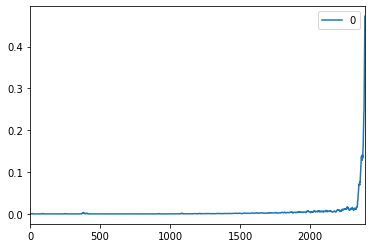

In [20]:
pd.DataFrame(y_pred).plot()

## Anomaly gap maximize net

* 제안 아이디어 검증

In [21]:
class UsadModel_AGM(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)

    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        self.history = []
        
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list, loss3_list = [], [], []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape, tf.GradientTape() as pg_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))
                    
                    real_recon1 = x_batch_train-self.w1
                    real_recon2 = x_batch_train-self.w2
                    fake_recon = x_batch_train-self.w3

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    pg_advantage = tf.stop_gradient(tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2)))
                    loss3 = -tf.reduce_mean(tf.math.log(self.w3+1e-6) * pg_advantage)
        
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                grads_ae3 = pg_tape.gradient(loss3, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae3, self.ae_model2.trainable_weights))
                
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                loss3_list.append(loss3)
                
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}, train_loss3: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list), np.mean(loss3_list)))
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
                
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        pg_advantage = tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2))
        loss3 = -tf.reduce_mean(tf.math.log(w3+1e-6) * pg_advantage)
        
        return {'val_loss1': loss1, 'val_loss2': loss2, 'val_loss3': loss3}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        batch_losses3 = [x['val_loss3'] for x in outputs]
        epoch_loss3 = tf.reduce_mean(batch_losses3)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy(), 'val_loss3': epoch_loss3.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2'], result['val_loss3']))

In [22]:
usad_agm = UsadModel_AGM(w_size,z_size)

In [23]:
usad_agm.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2063, val_loss2: 0.2080, val_loss2: -0.0068
Epoch [2], val_loss1: 0.1681, val_loss2: 0.1669, val_loss2: -0.0303
Epoch [3], val_loss1: 0.1154, val_loss2: 0.1174, val_loss2: -0.0316
Epoch [4], val_loss1: 0.0613, val_loss2: 0.0685, val_loss2: -0.0410
Epoch [5], val_loss1: 0.0339, val_loss2: 0.0393, val_loss2: -0.0280
Epoch [6], val_loss1: 0.0178, val_loss2: 0.0203, val_loss2: -0.0255
Epoch [7], val_loss1: 0.0085, val_loss2: 0.0092, val_loss2: -0.0311
Epoch [8], val_loss1: 0.0063, val_loss2: 0.0062, val_loss2: -0.0376
Epoch [9], val_loss1: 0.0062, val_loss2: 0.0058, val_loss2: -0.0366
Epoch [10], val_loss1: 0.0062, val_loss2: 0.0057, val_loss2: -0.0337
Epoch [11], val_loss1: 0.0062, val_loss2: 0.0057, val_loss2: -0.0322
Epoch [12], val_loss1: 0.0060, val_loss2: 0.0056, val_loss2: -0.0289
Epoch [13], val_loss1: 0.0058, val_loss2: 0.0053, val_loss2: -0.0252
Epoch [14], val_loss1: 0.0055, val_loss2: 0.0051, val_loss2: -0.0208
Epoch [15], val_loss1: 0.0053, val_loss2: 0

## Testing

In [24]:
results = model_usad.testing(test_loader)

In [25]:
y_pred = np.concatenate([np.stack(results[:-1]).flatten(), results[-1].flatten()])

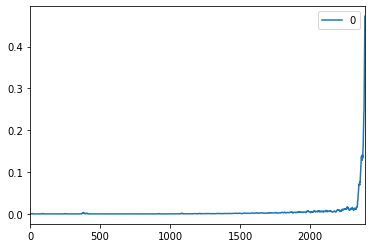

In [26]:
pd.DataFrame(y_pred).plot()